### <center> Analysis of the Calvetti Algorithm </center> ###

The Calvetti algorithm uses the standard particle filter to estimate a time dependent parameter $\beta_t$ of their SEIR. The theoretical basis for the technique comes from treating $\beta_t$ as though it were a state variable and thus the formal derivation of the particle filter as an approximation for the optimal Bayesian filter can be used. 

Effectively, at each time point $t$ we sample the joint distribution $P(X_t,\beta_t|z_t)$, where $z_t$ is the observation at time $t$ and $X_t$ is the latent state. The Calvetti paper does make a few basic changes to the algorithm to improve convergence, although in practice no clear benefit has been seen over the basic SIR particle filter. 


The first change of note is in step b

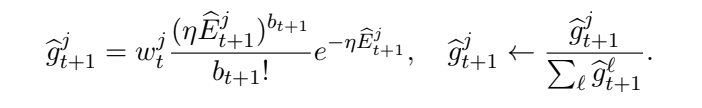

The particle weights are multiplied by the weights of the previous iteration on the first weight computation. These weights are denoted $\hat{g}_{t+1}^j$ for some particle $j$ as seen above. 

The particles are then resampled in the traditional manner using some resampling algorithm. Systematic resampling, multinomial resampling, e.t.c. 

The next step is to perturb both the parameters of the model and the state by some fixed values $\sigma_1$ for the state and $\sigma_2$ for the parameters. This is a slight modification on the traditional particle filter using a process in some literature known as gaussian roughening or kernel roughening. Traditional particle filters do perturb the parameters, however the latent state variables are generally left untouched. The goal of the state perturbation(gaussian roughening) is the combat sample impoverishment by allowing new states to be considered, and not just those in the previous iteration. 

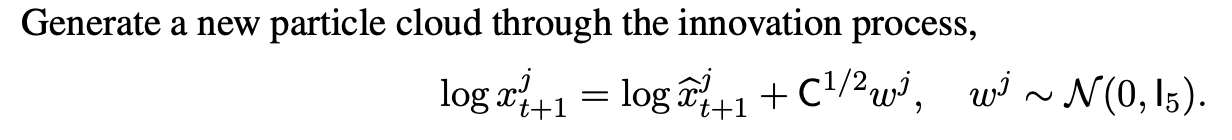

The particle $\hat{x}_{t+1}^j$ contains both the parameter $\beta_t^j$ and the state variables. The whole thing is perturbed according to the multivariate log - normal distribution but as the covariance matrix is diagonal with $\sigma_1$ and $\sigma_2$ across the diagonal this is effectively the same as a series of single variate log - normal perturbations. 

The reason for the log-normal perturbations vs normal perturbations is two fold. The first reason is that the state and parameter values must never be negative, and the log-normal distribution is strictly positive. 

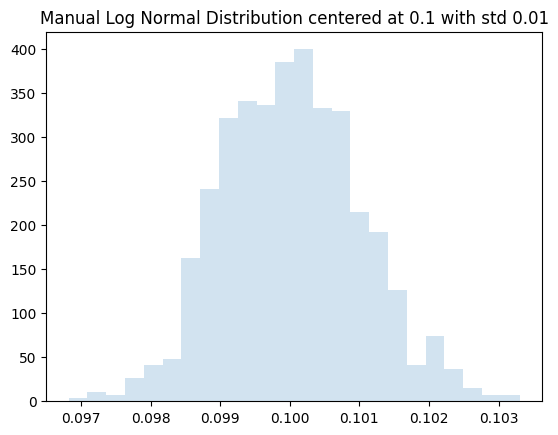

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

'''Verification the approach in the Calvetti paper is equivalent to the multivariate log-normal distribution'''

s=0.01

theta = 0.1

new_theta = [np.random.normal(np.log(theta),s) for _ in range(1000)]

plt.title(f"Manual Log Normal Distribution centered at {theta} with std {s}")
plt.hist(np.exp(new_theta), density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.show()




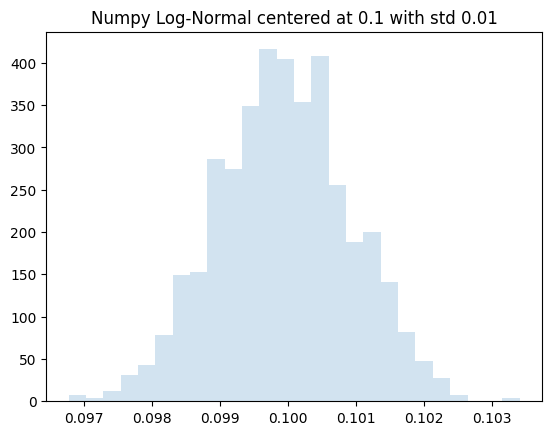

In [2]:
s=0.01

theta = 0.1

new_theta = [np.random.lognormal(mean=np.log(theta),sigma=s) for _ in range(1000)]

plt.title(f"Numpy Log-Normal centered at {theta} with std {s}")
plt.hist(new_theta, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.show()



A note here, we take the square root of the covariance matrix when using it in the perturbation step so a $\sigma_1$ of 0.1 corresponded to a standard deviation of 0.01. At the values we are using in simulation, the distribution seems relatively symmetric about the mean. Larger standard deviations lead to greater asymmetry in the distribution.

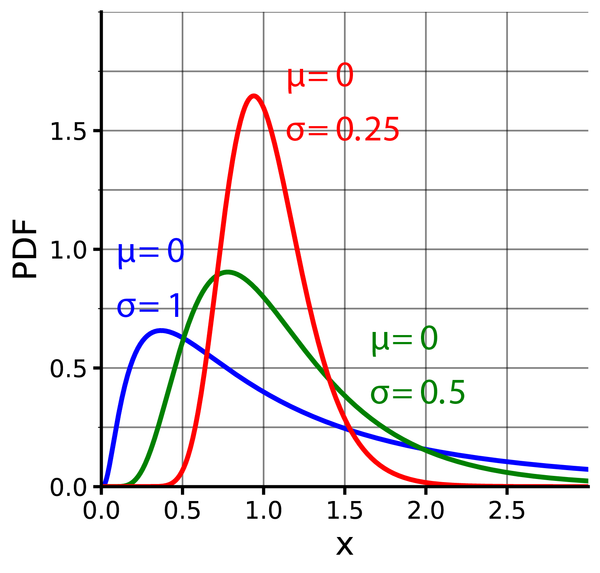

A comparison to normally perturbing the random variable. 

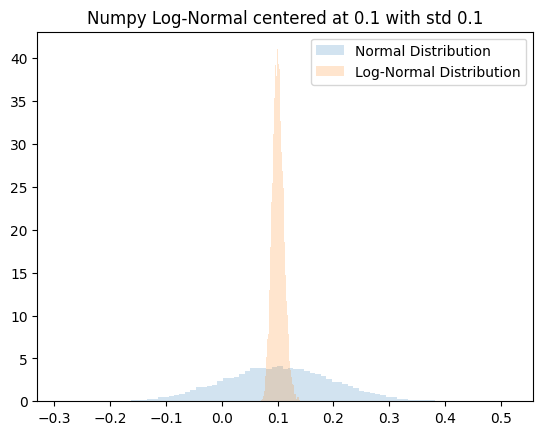

In [3]:
s=0.1

theta = 0.1

new_theta = [np.random.normal(theta,s) for _ in range(20000)]

plt.title(f"Numpy Normal centered at {theta} with std {s}")
plt.hist(new_theta, density=True, bins='auto', histtype='stepfilled', alpha=0.2,label="Normal Distribution")

theta = 0.1

new_theta = [np.random.lognormal(mean=np.log(theta),sigma=s) for _ in range(20000)]

plt.title(f"Numpy Log-Normal centered at {theta} with std {s}")
plt.hist(new_theta, density=True, bins='auto', histtype='stepfilled', alpha=0.2,label="Log-Normal Distribution")

plt.legend()
plt.show()

Note that as the parameter value $\theta$ is decreased, the scale of the perturbations is decreased as well, even as the variance is fixed. This could lead to an inefficient search of the parameter space, as $\theta$ estimates may get trapped in local minima and take multiple iterations to stabilize.

Drawing values from the multivariate normal distribution is done as follows(From Wikipedia)

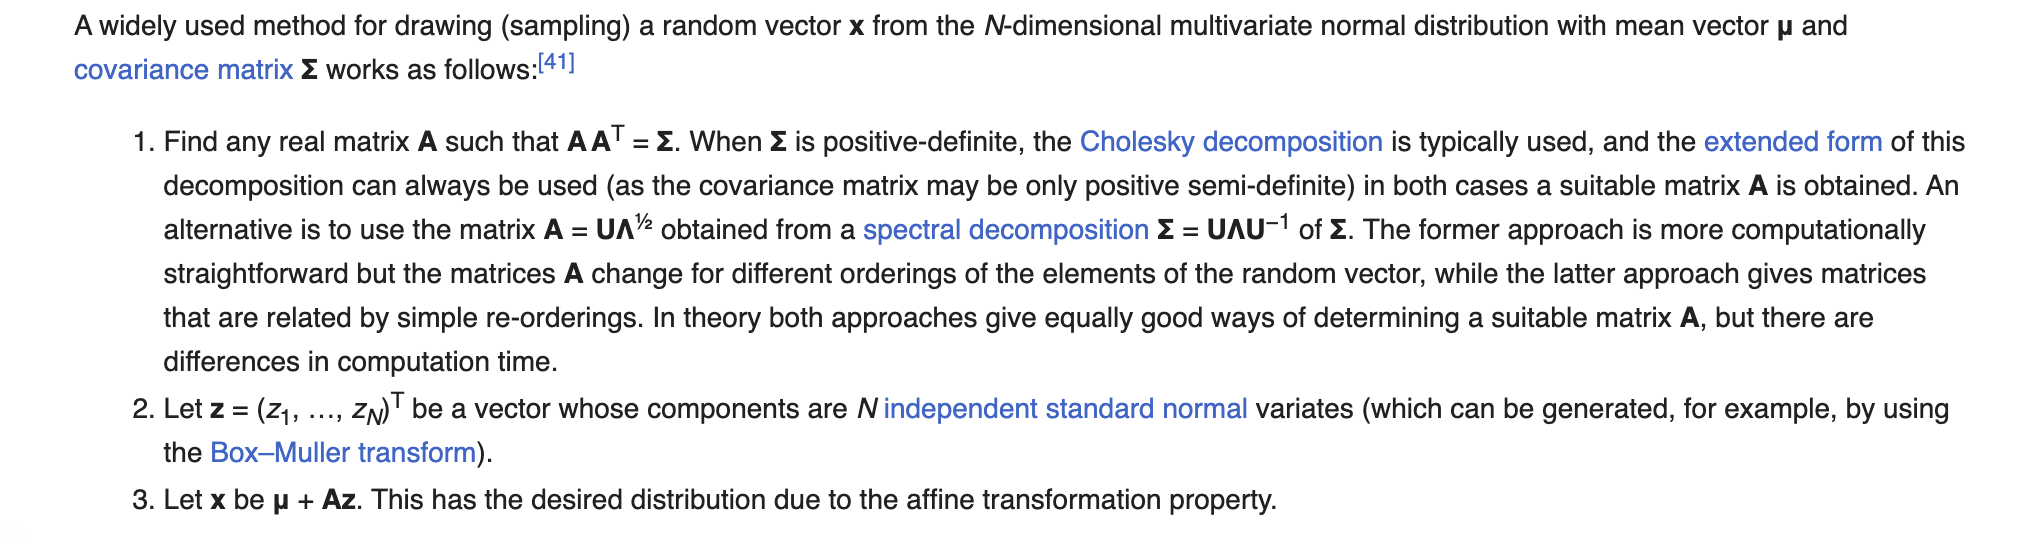

### <center> Results of the Simplified Algorithm(Baseline) ###

I forego step d for simplicity. The first weight calculation then omits the multiplication term $w_t^j$ and the weight ratio $w_{t+1}^{j} = \frac{g_{t+1}^j}{\hat{g}_{t+1}^j}$ is not computed. 

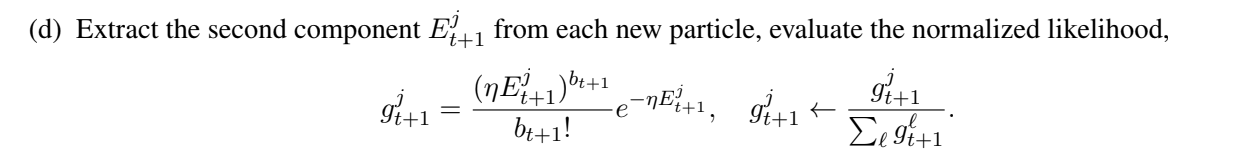

The compensation term $\beta_t \cdot e^{\alpha \cdot w_t}$, $w_t \sim \mathcal{N}(0,1)$ is also omitted. 


The results are comparable to the results seen in the Calvetti paper, albeit with more noise.

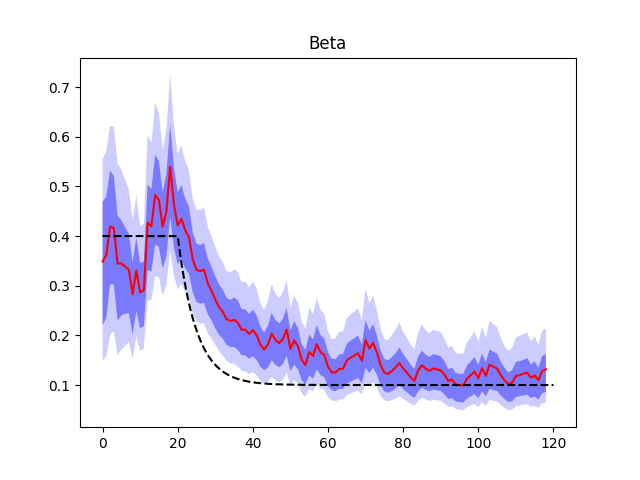

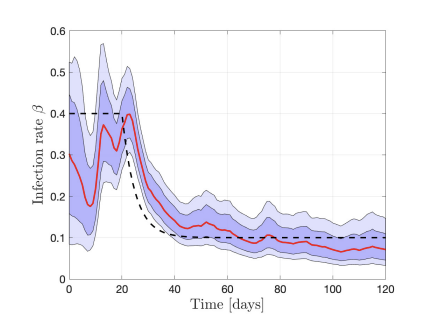

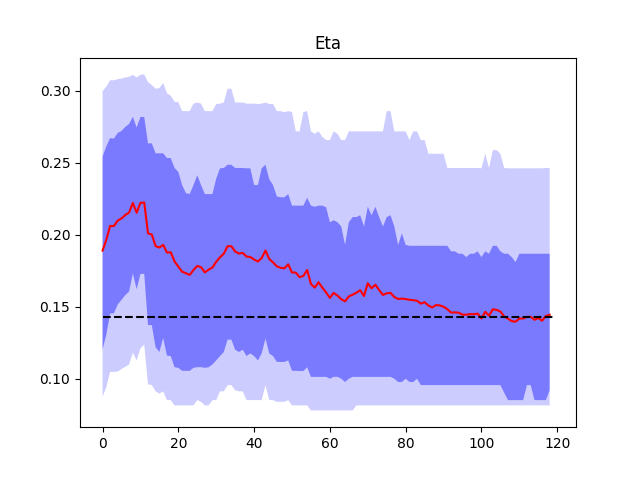

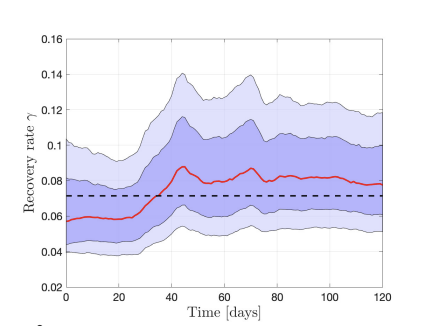

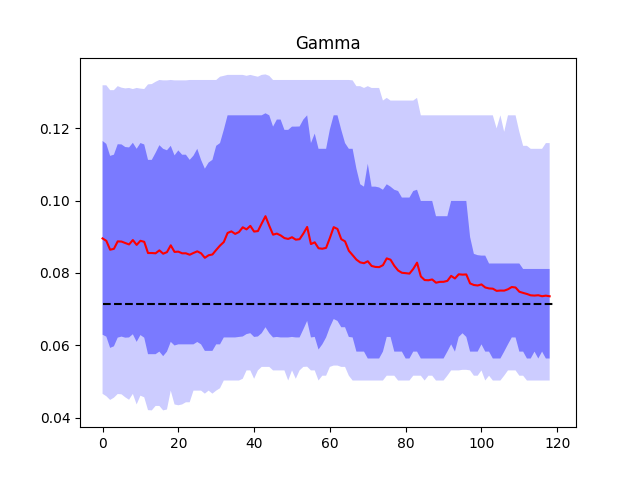

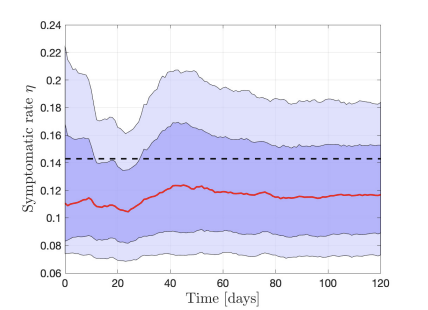

### <center> Adding the Correction Term ###

The next set of experiments adds the $\beta_t$ correction term $\beta_t \cdot e^{\alpha \cdot w_t}$, $w_t \sim \mathcal{N}(0,1)$. 

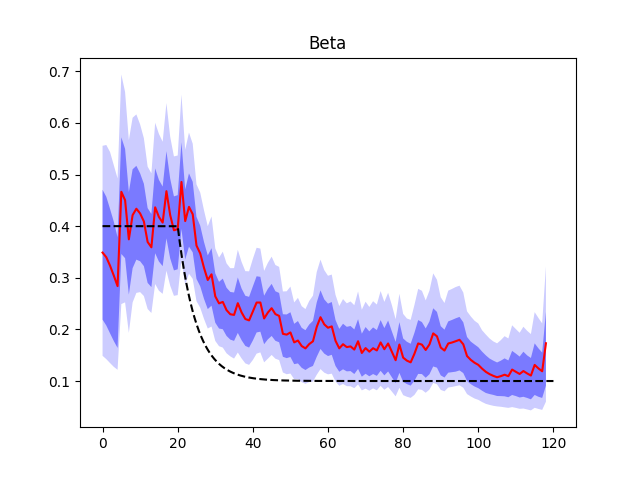

![Screenshot 2024-01-25 at 1.49.28 PM.png](<attachment:Screenshot 2024-01-25 at 1.49.28 PM.png>)

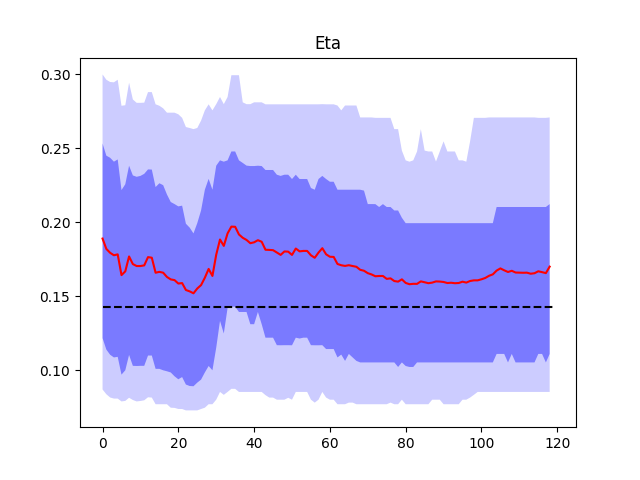

![Screenshot 2024-02-06 at 1.04.02 PM.png](<attachment:Screenshot 2024-02-06 at 1.04.02 PM.png>)

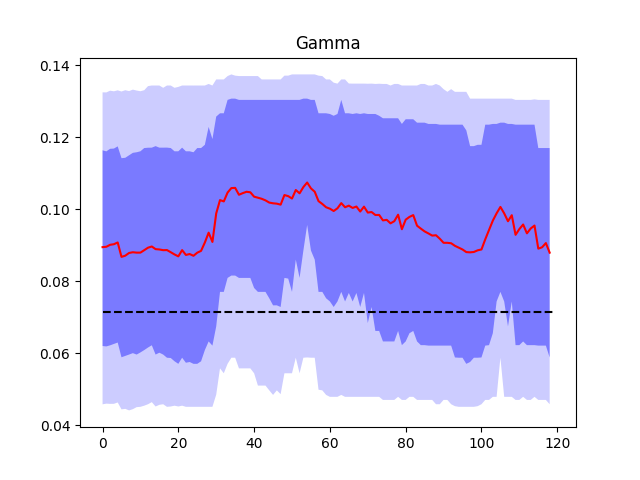

![Screenshot 2024-02-06 at 1.03.02 PM.png](<attachment:Screenshot 2024-02-06 at 1.03.02 PM.png>)
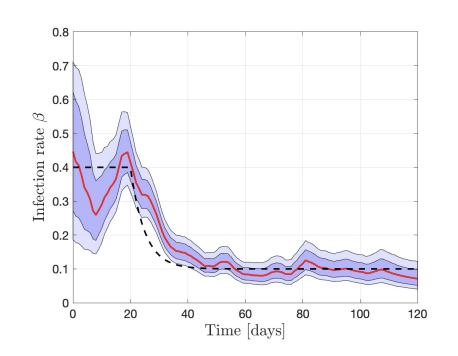
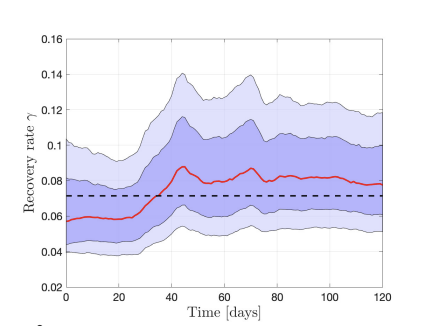
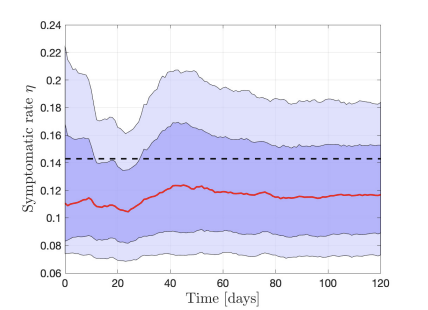

### <center> Adding the Second Weight Calculation ###

The Calvetti paper makes use of step d, which recomputes the weights after perturbation. The first weight calculation is also multiplied by the ratio of the posterior and prior weights. 



In [6]:
import numpy as np
N = 1000

'''Analysis if the weights are non normalized'''

theta = np.array([np.log([np.random.uniform(0,1) for _ in range(3)]) for _ in range(N)])

weights = np.array([np.random.uniform(0,1) for _ in range(N)])

weights_norm = weights / np.sum(weights)

psi = np.zeros(3)

for i in range(N):
    psi += weights_norm[i] * theta[i,:]

print(f"normalized weights: {psi}")

psi = np.zeros(3)

for i in range(N):
    psi += weights[i] * theta[i,:]

print(f"un-normalized weights: {psi}")

normalized weights: [-1.00095479 -1.00933101 -0.97178277]
un-normalized weights: [-501.36490632 -505.56044669 -486.75303343]


The following results use the normalized weight ratio in perturbation and resampling calculation. 

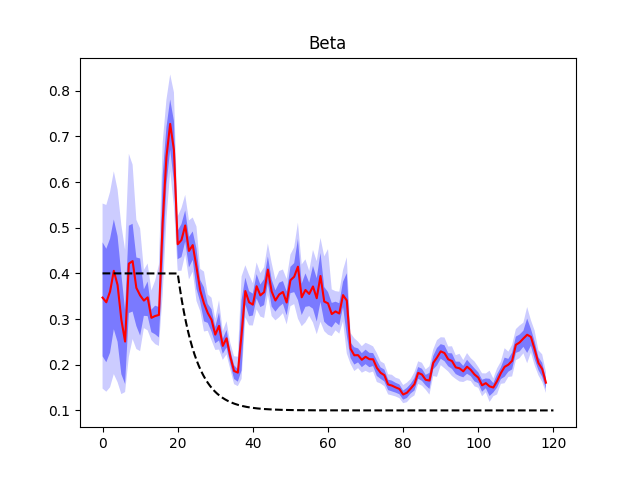

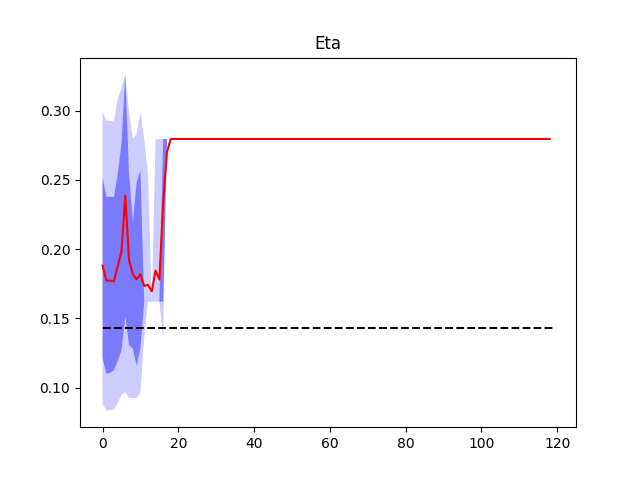

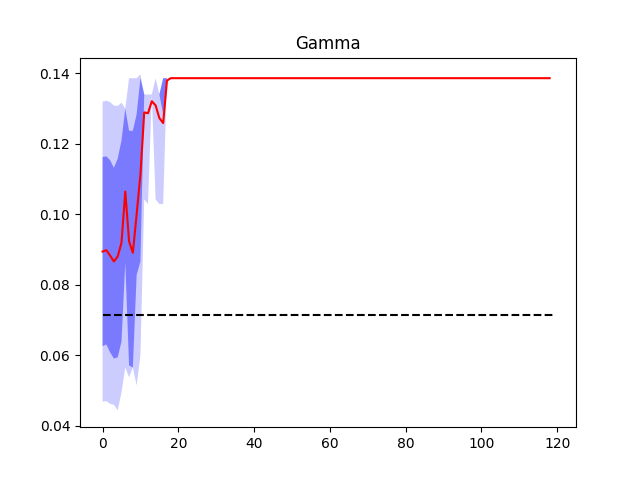

I tried various approaches, normalizing the weight ratio $w_{t+1}^j$, leaving it unnormalized , using the prior weights $g_{t+1}^j$ for computation of $\xi_{t+1}$ and $\Sigma_{t+1}$, and the ratio just for adjusting the prior weights $\hat{g}_{t+1}$. However, the results all exhibit this behavior wherein the parameter values converge to a fixed value and stabilize, and $\beta$ exhibits random walk dynamics. 

Multiplying by the weights of the previous iteration $g_{t+1}^j$ foregoing the weight ratio. 


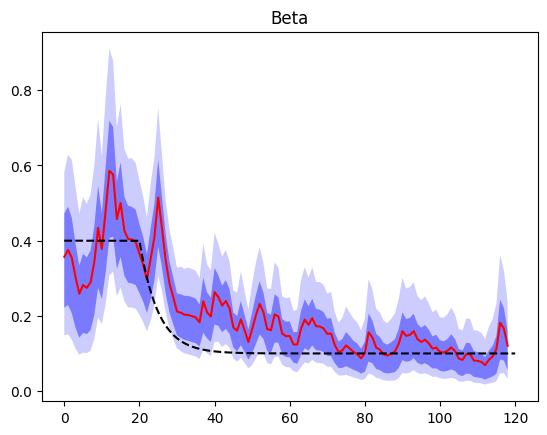

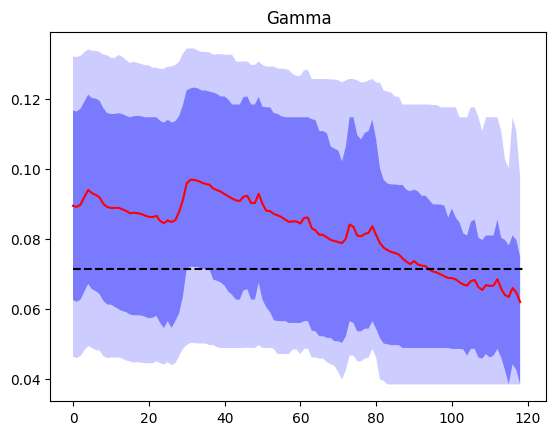

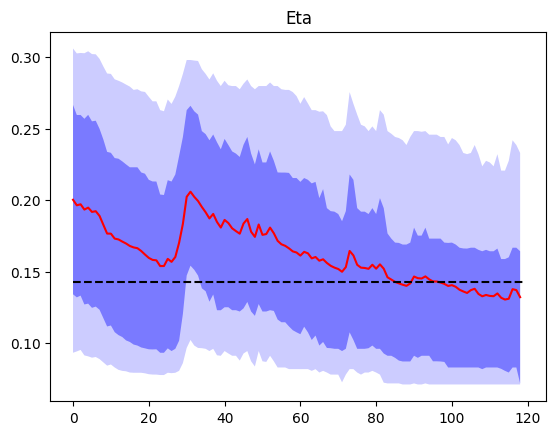

I noticed an omission in my code which willl change the behavior of the algorithm. When the weights are recomputed in Calvetti et. al. 
the perturbed value of the compartment $E_{t+1}^j$ is used. I am not updating the observation after perturbation, which is causing the posterior weights $g_{t+1}^j$ to be equal to $g_t^j$. 